# Quickstart

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bdms

In [2]:
d = 2
birth_process = bdms.poisson.DiscreteProcess([1.0, 2.0])
death_process = bdms.poisson.ConstantProcess(1.0)
mutation_process = bdms.poisson.ConstantProcess(1.0)
mutator = bdms.mutators.DiscreteMutator(range(d), np.array([[0, 1], [1, 0]]))

In [3]:
rng = np.random.default_rng(seed=0)

In [4]:
tree = bdms.Tree()
tree.state = 0

time_to_sampling = 10.0

tree.evolve(
    time_to_sampling,
    birth_process=birth_process,
    death_process=death_process,
    mutation_process=mutation_process,
    mutator=mutator,
    min_survivors=100,
    seed=rng,
)

In [5]:
len(tree)

963

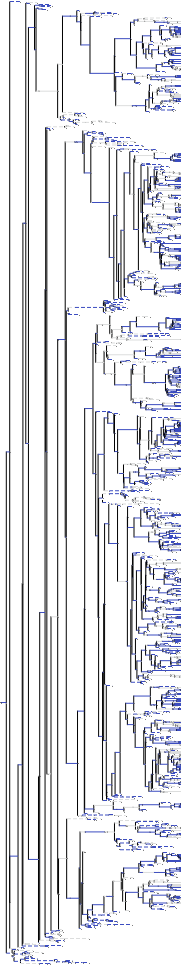

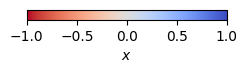

In [6]:
tree.render("state", "%%inline")

## Inhomogeneous processes

We subclass the abstract class `bdms.poisson.InhomogeneousProcess`.
To concretize, we must define the `λ_inhomogeneous` method.
We'll use this for a death rate that exponentially increases over time, and is independent of state.

In [11]:
class ExponentialRateProcess(bdms.poisson.InhomogeneousProcess):
    def __init__(self, initial_rate, growth_rate):
        self.initial_rate = initial_rate
        self.growth_rate = growth_rate
    def λ_inhomogeneous(self, state, t):
        return self.initial_rate * np.exp(self.growth_rate * t)

In [14]:
death_rate = ExponentialRateProcess(1.0, 0.1)

In [15]:
tree = bdms.Tree()
tree.state = 0

In [16]:
tree.evolve(
    time_to_sampling,
    birth_process=birth_process,
    death_process=death_process,
    mutation_process=mutation_process,
    mutator=mutator,
    min_survivors=100,
    seed=rng,
)

In [ ]:
# NBVAL_IGNORE_OUTPUT

x_grid = np.arange(-5, 5, 0.1)

plt.figure(figsize=(7, 4))
plt.axvline(0, color="k", linestyle="--")
for t in np.linspace(0, 5, 6):
    plt.plot(
        x_grid,
        birth_rate.λ_phenotype_time(x_grid, t),
        label=f"birth rate ($t={t}$)",
        alpha=0.5,
    )
plt.plot(x_grid, death_rate.λ_phenotype(x_grid), label="death rate", alpha=0.5)
plt.plot(x_grid, mutation_rate.λ_phenotype(x_grid), label="mutation rate", alpha=0.5)
plt.fill_between(
    x_grid,
    mutator.prob(0, x_grid),
    color="lightgrey",
    label="distribution of phenotypic\neffects of mutations",
)
plt.xlabel("phenotype")
# plt.ylabel('event rate')
plt.ylim(0, None)
plt.legend()
plt.show()

#### Simulate

In [ ]:
time_to_sampling = 5
for iter in range(1000):
    try:
        tree = bdms.Tree()
        tree.state = 0
        tree.evolve(
            time_to_sampling,
            birth_response=birth_rate,
            death_response=death_rate,
            mutation_response=mutation_rate,
            mutator=mutator,
            min_survivors=100,
            birth_mutations=False,
            seed=rng,
        )
        print(f"try {iter + 1} succeeded, tip count: {len(tree)}")
        break
    except bdms.tree.TreeError as e:
        print(f"try {iter + 1} failed, {e}", flush=True)
        continue

In [ ]:
tree.sample_survivors(n=20, seed=rng)
tree.prune()

In [ ]:
# NBVAL_SKIP

tree.render("x", "%%inline")

### Rate-modulated model

#### Parameters

##### Response functions

We'll modulate the birth rate to approximate a capacity constraint

In [ ]:
def f(λ, x, t):
    return λ * np.exp(-0.2 * t)

In [ ]:
t = np.linspace(0, 5)
plt.figure(figsize=(4, 3))
for λ in [0.1, 0.5, 1, 1.5]:
    plt.plot(t, f(λ, None, t), label=f"$\lambda={λ}$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde\lambda(\lambda, t)$")
plt.legend()
plt.show()

In [ ]:
birth_rate = bdms.poisson.ModulatedRateResponse(
    bdms.poisson.SigmoidResponse(xscale=2.0, xshift=0, yscale=3, yshift=0.0), f
)

In [ ]:
# NBVAL_IGNORE_OUTPUT

x_grid = np.arange(-5, 5, 0.1)

plt.figure(figsize=(7, 4))
plt.axvline(0, color="k", linestyle="--")
for t in np.linspace(0, 5, 6):
    plt.plot(
        x_grid,
        birth_rate.λ_phenotype_time(x_grid, t),
        label=f"birth rate ($t={t}$)",
        alpha=0.5,
    )
plt.plot(x_grid, death_rate.λ_phenotype(x_grid), label="death rate", alpha=0.5)
plt.plot(x_grid, mutation_rate.λ_phenotype(x_grid), label="mutation rate", alpha=0.5)
plt.fill_between(
    x_grid,
    mutator.prob(0, x_grid),
    color="lightgrey",
    label="distribution of phenotypic\neffects of mutations",
)
plt.xlabel("phenotype")
# plt.ylabel('event rate')
plt.ylim(0, None)
plt.legend()
plt.show()

#### Simulate

In [ ]:
time_to_sampling = 5
for iter in range(1000):
    try:
        tree = bdms.Tree()
        tree.state = 0
        tree.evolve(
            time_to_sampling,
            birth_response=birth_rate,
            death_response=death_rate,
            mutation_response=mutation_rate,
            mutator=mutator,
            min_survivors=100,
            capacity=1000,
            birth_mutations=False,
            seed=rng,
        )
        print(f"try {iter + 1} succeeded, tip count: {len(tree)}")
        break
    except bdms.tree.TreeError as e:
        print(f"try {iter + 1} failed, {e}", flush=True)
        continue

In [ ]:
tree.sample_survivors(n=20, seed=rng)
tree.prune()

In [ ]:
# NBVAL_SKIP

tree.render("x", "%%inline")